In [2]:
import os
import shutil


def move_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            shutil.move(file_path, os.path.join(directory, file))


# Replace 'directory_path' with the path to your target directory
directory_path = './face/other/lfw/'
move_files(directory_path)


In [ ]:
from PIL import Image
import os


def resize_images(directory, output_size):
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(directory, filename)
            try:
                with Image.open(image_path) as image:
                    resized_image = image.resize(output_size)
                    resized_image.save(os.path.join(directory, filename))
            except Exception as e:
                print(f"Error processing image {filename}: {e}")


# Replace 'directory_path' with the path to your target directory
directory_path = './face/other'
output_size = (200, 200)
resize_images(directory_path, output_size)


In [6]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
from sklearn.datasets import fetch_lfw_people

directory = "./face"


categories = ["me","other"]

data = []

for category in categories:
    path = os.path.join(directory, category)
    label = categories.index(category)

    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path, 0)

        # Resize the image to a consistent size (e.g., 200x200)
        image = cv2.resize(image, (200, 200))

        # Flatten the image
        image = np.array(image).flatten()

        data.append([image, label])

data = np.array(data, dtype=object)


# print(len(data))

# print(data)


pick_in = open("data.pickle", 'wb')

pickle.dump(data, pick_in)

pick_in.close()


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
The accuracy socre is:  0.9975339087546239
The prediction is:  other


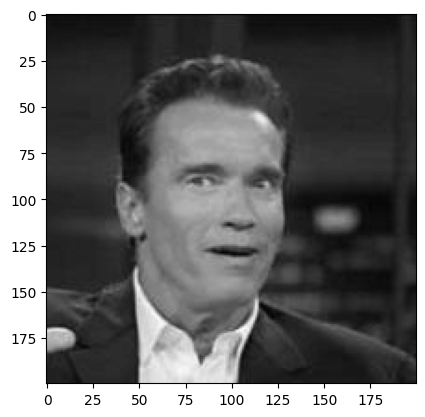

In [7]:
import cv2
import numpy as np
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt


pick_in = open(
	".\data.pickle", "rb")
data = pickle.load(pick_in)
pick_in.close()


random.shuffle(data)

features = []
labels = []

for feature, label in data:
	features.append(feature)
	labels.append(label)

# print(labels)
# print(features)
# print("len of labels: ", len(labels))
# print("len of features: ", len(features))

features = np.array(features, dtype=np.uint8)
labels = np.array(labels, dtype=np.uint8)
X_train, X_test, y_train, y_test = train_test_split(
	features, labels, test_size=0.25)


print(type(X_train))
print(type(y_train))
svm = SVC(C=1, kernel='poly', gamma='auto')

svm.fit(X_train, y_train)


prediction = svm.predict(X_test)

accuracy = svm.score(X_test, y_test)


print("The accuracy socre is: ", accuracy)


print('The prediction is: ', categories[prediction[0]])

my_pet = X_test[0].reshape(200, 200)

plt.imshow(my_pet, cmap='gray')
plt.show()


pick = open("model.sav", "wb")
pickle.dump(svm, pick)
pick.close()


(10053, 40000)
(10053,)
accuracy:  1.0
prediction is:  other


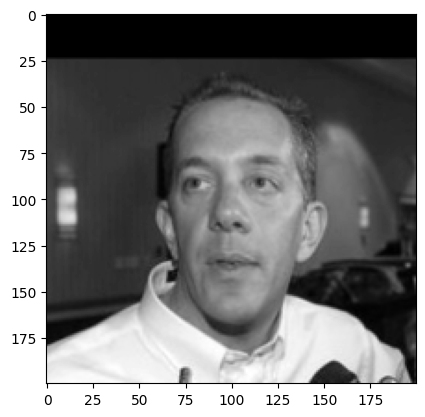

In [5]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random


pick_in = open(
	".\\data.pickle", "rb")
data = pickle.load(pick_in)
pick_in.close()

random.shuffle(data)

features = []
labels = []

for feature, label in data:
	features.append(feature)
	labels.append(label)

# print(labels)
# print(features)
# print("len of labels: ", len(labels))
# print("len of features: ", len(features))

features = np.array(features, dtype=np.uint8)
labels = np.array(labels, dtype=np.uint8)
X_train, X_test, y_train, y_test = train_test_split(
	features, labels, test_size=0.25)

print(X_train.shape)
print(y_train.shape)


pick = open("model.sav", 'rb')
svm = pickle.load(pick)
pick.close()


categories = ["me", "other"]


print("accuracy: ", svm.score(X_test, y_test))

prediction = svm.predict(X_test)
print("prediction is: ", categories[prediction[0]])


who = X_test[0].reshape(200, 200)
plt.imshow(who, cmap='gray')
plt.show()


In [13]:
from sklearn.svm import SVC
import random
from sklearn.model_selection import train_test_split
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

# Load the trained model
pick = open("model.sav", "rb")
svm = pickle.load(pick)
pick.close()

# Define the face cascade classifier
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Initialize the video capture
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.1, minNeighbors=10, minSize=(40, 40))

    for (x, y, w, h) in faces:
        # Extract the face region
        face = gray[y:y+h, x:x+w]

        # Resize the face image to match the training data size
        face = cv2.resize(face, (200, 200))

        # Flatten the face image
        face = np.array(face).flatten()

        # Predict the label of the face using the trained SVM model
        prediction = svm.predict([face])

        # Determine the color and label for the rectangle based on the prediction
        if prediction == 0:  # Assuming AdrienBrody is label 0
            color = (0, 255, 0)  # Green
            label = "alireza nasoodi"
        else:
            color = (0, 0, 255)  # Red
            label = "Unknown"

        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)

        # Put the label text above the rectangle
        cv2.putText(frame, label, (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Display the resulting frame
    cv2.imshow('Face Detection', frame)

    # Calculate and display the accuracy score
    # accuracy = svm.score(X_test, y_test)
    # accuracy_text = "Accuracy: {:.2f}".format(accuracy)
    # cv2.putText(frame, accuracy_text, (10, 30),
    #             cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # Display the resulting frame
    cv2.imshow('Face Detection', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
# Release the video capture and close all windows
cap.release()
cv2.destroyAllWindows()
